In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
from torch.autograd import Variable
from torch.optim import lr_scheduler
import argparse

import time
import copy
from torchvision.utils import save_image

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/ECE1512ProjB

/content/drive/MyDrive/ECE1512ProjB


In [ ]:
from networks import MLP, ConvNet, LeNet, AlexNet, AlexNetBN, VGG11, VGG11BN, ResNet18, ResNet18BN_AP, ResNet18BN
from utils import get_loops, get_dataset, get_network, get_eval_pool, evaluate_synset, get_daparam, match_loss, get_time, TensorDataset, epoch, DiffAugment, ParamDiffAug

# Dataset Condensation with Distribution Matching and Visualization

In [ ]:
parser = argparse.ArgumentParser(description='Parameter Processing')
parser.add_argument('--dataset', type=str, default='CIFAR10', help='dataset')
parser.add_argument('--model', type=str, default='ConvNet', help='model')
parser.add_argument('--ipc', type=int, default=10, help='image(s) per class')
parser.add_argument('--eval_mode', type=str, default='S', help='eval_mode') # S: the same to training model, M: multi architectures,  W: net width, D: net depth, A: activation function, P: pooling layer, N: normalization layer,
parser.add_argument('--num_exp', type=int, default=5, help='the number of experiments')
parser.add_argument('--num_eval', type=int, default=20, help='the number of evaluating randomly initialized models')
parser.add_argument('--epoch_eval_train', type=int, default=300, help='epochs to train a model with synthetic data') # it can be small for speeding up with little performance drop
parser.add_argument('--Iteration', type=int, default=100, help='training iterations')
parser.add_argument('--lr_img', type=float, default=0.1, help='learning rate for updating synthetic images')
parser.add_argument('--lr_net', type=float, default=0.01, help='learning rate for updating network parameters')
parser.add_argument('--batch_real', type=int, default=256, help='batch size for real data')
parser.add_argument('--batch_train', type=int, default=256, help='batch size for training networks')
parser.add_argument('--init', type=str, default='real', help='noise/real: initialize synthetic images from random noise or randomly sampled real images.')
parser.add_argument('--dsa_strategy', type=str, default='color_crop_cutout_flip_scale_rotate', help='differentiable Siamese augmentation strategy')
parser.add_argument('--data_path', type=str, default='data', help='dataset path')
parser.add_argument('--save_path', type=str, default='result', help='path to save results')
parser.add_argument('--dis_metric', type=str, default='ours', help='distance metric')

args, unknown = parser.parse_known_args()
args.init = 'real'
args.method = 'DM'
args.outer_loop, args.inner_loop = get_loops(args.ipc)
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.dsa_param = ParamDiffAug()
args.dsa = False if args.dsa_strategy in ['none', 'None'] else True

if not os.path.exists(args.data_path):
    os.mkdir(args.data_path)

if not os.path.exists(args.save_path):
    os.mkdir(args.save_path)

channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset(args.dataset, args.data_path)

''' organize the real dataset '''
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]

for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(args.device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=args.device)

for c in range(num_classes):
    print('class c = %d: %d real images'%(c, len(indices_class[c])))

def get_images(c, n): # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]

for ch in range(channel):
    print('real images channel %d, mean = %.4f, std = %.4f'%(ch, torch.mean(images_all[:, ch]), torch.std(images_all[:, ch])))


''' initialize the synthetic data '''
image_syn = torch.randn(size=(num_classes*args.ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=args.device)
label_syn = torch.tensor([np.ones(args.ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=args.device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

if args.init == 'real':
    print('initialize synthetic data from random real images')
    for c in range(num_classes):
        image_syn.data[c*args.ipc:(c+1)*args.ipc] = get_images(c, args.ipc).detach().data
else:
    print('initialize synthetic data from random noise')

''' training '''
optimizer_img = torch.optim.SGD([image_syn, ], lr=args.lr_img, momentum=0.5) # optimizer_img for synthetic data
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(args.device)
print('%s training begins'%get_time())

for it in range(args.Iteration+1):

    ''' Train synthetic data '''
    net = get_network(args.model, channel, num_classes, im_size).to(args.device) # get a random model
    net.train()
    net_parameters = list(net.parameters())
    optimizer_net = torch.optim.SGD(net.parameters(), lr=args.lr_net)  # optimizer_img for synthetic data
    optimizer_net.zero_grad()
    embed = net.module.embed if torch.cuda.device_count() > 1 else net.embed # for GPU parallel

    loss_avg = 0
    args.dc_aug_param = None  # Mute the DC augmentation when learning synthetic data (in inner-loop epoch function) in oder to be consistent with DC paper.
  

    ''' update synthetic data '''
    if 'BN' not in args.model: # for ConvNet
        loss = torch.tensor(0.0).to(args.device)
        for c in range(num_classes):
            img_real = get_images(c, args.batch_real)
            img_syn = image_syn[c*args.ipc:(c+1)*args.ipc].reshape((args.ipc, channel, im_size[0], im_size[1]))

            output_real = embed(img_real).detach()
            output_syn = embed(img_syn)

            loss += torch.sum((torch.mean(output_real, dim=0) - torch.mean(output_syn, dim=0))**2)

    else: # for ConvNetBN
        images_real_all = []
        images_syn_all = []
        loss = torch.tensor(0.0).to(args.device)
        for c in range(num_classes):
            img_real = get_images(c, args.batch_real)
            img_syn = image_syn[c*args.ipc:(c+1)*args.ipc].reshape((args.ipc, channel, im_size[0], im_size[1]))

            images_real_all.append(img_real)
            images_syn_all.append(img_syn)

        images_real_all = torch.cat(images_real_all, dim=0)
        images_syn_all = torch.cat(images_syn_all, dim=0)

        output_real = embed(images_real_all).detach()
        output_syn = embed(images_syn_all)

        loss += torch.sum((torch.mean(output_real.reshape(num_classes, args.batch_real, -1), dim=1) - torch.mean(output_syn.reshape(num_classes, args.ipc, -1), dim=1))**2)



    optimizer_img.zero_grad()
    loss.backward()
    optimizer_img.step()
    loss_avg += loss.item()


    loss_avg /= (num_classes)

    if it%10 == 0:
        print('%s iter = %04d, loss = %.4f' % (get_time(), it, loss_avg))
        
        ''' Test '''  
        accs = []
        image_syn_eval, label_syn_eval = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach()) # avoid any unaware modification
        _, acc_train, acc_test = evaluate_synset(1, net, image_syn_eval, label_syn_eval, testloader, args)
        accs.append(acc_test)


Files already downloaded and verified
Files already downloaded and verified
class c = 0: 5000 real images
class c = 1: 5000 real images
class c = 2: 5000 real images
class c = 3: 5000 real images
class c = 4: 5000 real images
class c = 5: 5000 real images
class c = 6: 5000 real images
class c = 7: 5000 real images
class c = 8: 5000 real images
class c = 9: 5000 real images
real images channel 0, mean = -0.0000, std = 1.2211
real images channel 1, mean = -0.0002, std = 1.2211
real images channel 2, mean = 0.0002, std = 1.3014
initialize synthetic data from random real images
[2022-11-30 03:58:19] training begins


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


[2022-11-30 03:58:26] iter = 0000, loss = 27.0261


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignor

[2022-11-30 03:58:32] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.044244 train acc = 1.0000, test acc = 0.3119
[2022-11-30 03:58:34] iter = 0010, loss = 26.7013
[2022-11-30 03:58:40] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.013749 train acc = 1.0000, test acc = 0.3281
[2022-11-30 03:58:41] iter = 0020, loss = 25.5348
[2022-11-30 03:58:47] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.032445 train acc = 1.0000, test acc = 0.3360
[2022-11-30 03:58:49] iter = 0030, loss = 23.2698
[2022-11-30 03:58:55] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.017275 train acc = 1.0000, test acc = 0.3365
[2022-11-30 03:58:56] iter = 0040, loss = 21.3982
[2022-11-30 03:59:02] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.003449 train acc = 1.0000, test acc = 0.3547
[2022-11-30 03:59:04] iter = 0050, loss = 21.7977
[2022-11-30 03:59:10] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.003484 train acc = 1.0000, test acc = 0.3564


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


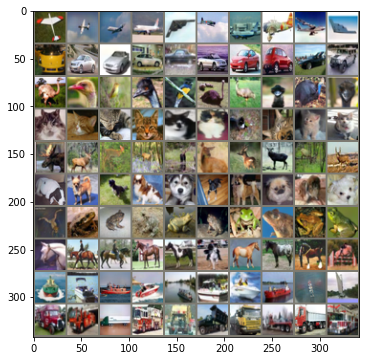

In [ ]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
# images, labels = next(iter(data_loader_train))
dataset_syn = torchvision.utils.make_grid(image_syn, nrow=10).cpu()
dataset_syn = dataset_syn.numpy().transpose(1,2,0)
dataset_syn = dataset_syn*std+mean
print([int(label_syn[i]) for i in range(100)])
plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(dataset_syn)

# Train from Scratch and Test

In [ ]:
data_train = TensorDataset(image_syn.to('cpu'), label_syn.to('cpu'))
trainloader = torch.utils.data.DataLoader(data_train, batch_size=256, shuffle=True, num_workers=2)
# print(len(data_train))

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=mean, std=std)])

data_test = datasets.CIFAR10(root="./data/",
               transform = transform,
               train = False)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                         batch_size = 256,
                         shuffle = True,
                         num_workers=2)

net = get_network('ConvNet', 3 , num_classes = 10, im_size=(32, 32))
net = net.to('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(),lr=0.01,momentum=0.95)  # optimizer_img for synthetic data
scheduler = lr_scheduler.CosineAnnealingLR(optimizer_net,20)
num_epochs = 20

In [ ]:
for epoch in range(num_epochs):
  net.train(True) # Train mode 
  loss_tot = 0.0
  correct_tot = 0
  print("Epoch {}/{}".format(epoch, num_epochs))
  print("-"*10)
  for data in trainloader:
    imgs, labels = data
    imgs = imgs.to('cuda' if torch.cuda.is_available() else 'cpu')
    labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer_net.zero_grad() # clear the grad
    outputs = net(imgs) # forward
    loss = criterion(outputs,labels) # loss calculation
    pred = torch.argmax(outputs,dim=1)
    loss_tot += loss.data
    correct_tot += torch.sum(pred == labels.data)
    loss.backward()
    optimizer_net.step()
  scheduler.step()
    
  net.train(False)
  testing_correct = 0
  for data in data_loader_test:
    img_test, label_test = data
    img_test = img_test.to('cuda' if torch.cuda.is_available() else 'cpu')
    label_test = label_test.to('cuda' if torch.cuda.is_available() else 'cpu')
    outputs = net(img_test)
    pred = torch.argmax(outputs,dim=1)
    testing_correct += torch.sum(pred == label_test.data)
  print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}%".format(loss_tot/100,
                                           100*correct_tot/100,
                                           100*testing_correct/len(data_test)))


Epoch 0/20
----------
Loss is:0.0234, Train Accuracy is:10.0000%, Test Accuracy is:11.7900%
Epoch 1/20
----------
Loss is:0.0225, Train Accuracy is:21.0000%, Test Accuracy is:16.4400%
Epoch 2/20
----------
Loss is:0.0211, Train Accuracy is:35.0000%, Test Accuracy is:19.1800%
Epoch 3/20
----------
Loss is:0.0199, Train Accuracy is:48.0000%, Test Accuracy is:19.8500%
Epoch 4/20
----------
Loss is:0.0187, Train Accuracy is:52.0000%, Test Accuracy is:21.3500%
Epoch 5/20
----------
Loss is:0.0174, Train Accuracy is:57.0000%, Test Accuracy is:23.4600%
Epoch 6/20
----------
Loss is:0.0160, Train Accuracy is:71.0000%, Test Accuracy is:24.6400%
Epoch 7/20
----------
Loss is:0.0149, Train Accuracy is:77.0000%, Test Accuracy is:24.5100%
Epoch 8/20
----------
Loss is:0.0139, Train Accuracy is:78.0000%, Test Accuracy is:24.7900%
Epoch 9/20
----------
Loss is:0.0131, Train Accuracy is:80.0000%, Test Accuracy is:25.2900%
Epoch 10/20
----------
Loss is:0.0123, Train Accuracy is:83.0000%, Test Accuracy